# Lupus Cohort

This is a cohort of individuals with Lupus. I pulled this dataset because it contains a group of patients with sorted (purified cell populations) blood samples profiled across multiple different cell types. 

In [1]:
import os 
if os.getcwd().endswith('Other'):
    os.chdir('..')

In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [3]:
from Setup.MethylationAgeModels import *

importing IPython notebook from Setup/MethylationAgeModels

In [4]:
GSE59250_MATRIX = './data/GSE59250_series_matrix.txt.gz'
GSE59250_MATRIX = os.path.abspath(GSE59250_MATRIX)
URL = ('ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE59nnn/GSE59250/'
       'matrix/GSE59250_series_matrix.txt.gz')
if not os.path.isfile(GSE59250_MATRIX):
    !curl $URL -o $GSE59250_MATRIX

In [5]:
ann = pd.read_table(GSE59250_MATRIX, skiprows=26, nrows=36, index_col=0)

In [6]:
a2 = ann.ix['!Sample_characteristics_ch1']

In [7]:
cell_type = a2.ix[0].map(lambda s: s.split(': ')[1])
cell_type.value_counts()

CD4+ T-cells                      149
CD19+ B-Cells                     104
CD14+ Monocytes                    55
CD25+CD127- Regulatory T-cells     42
CD45RO+RA- Memory T-cells          42
CD45RO-RA+ Naive T-cells           42
dtype: int64

In [8]:
disease = a2.ix[1].map(lambda s: s.split(': ')[1])
disease.value_counts()

Systemic Lupus Erythematosus    228
control                         206
dtype: int64

In [9]:
patient = pd.Series({i: i.split('.')[0] for i in cell_type.index})
patient.value_counts().value_counts()

2    55
3    45
4    38
7     2
6     2
5     2
1     1
dtype: int64

In [10]:
data = pd.read_table(GSE59250_MATRIX, skiprows=64, index_col=0,
                     header=None, names=a2.columns,
                     na_values=['null'])
#data = data.dropna()
data = data.fillna(data.mean(1))
gs = pd.read_csv('./data/Hannum_gold_standard.csv', header=None, 
                 index_col=0, squeeze=True)
data = data.T.fillna(gs).T

In [11]:
h1 = run_horvath_model(data)
h2 = run_hannum_model(data)

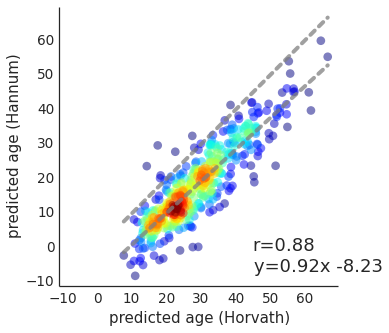

In [12]:
plot_regression(h1, h2, density=True)

In [13]:
diff = ((h1 - h2) / ((h1 + h2) * .5)).abs()
k = ti(diff < .5)

In [14]:
combined = (h1 + h2) / 2
combined = combined

#### Clinical annotations

This is a table in a word document. You are going to have to download it and pop it into Excel. The table is available from [this paper](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1003678#s5). Here is a [direct link to the Word document](http://journals.plos.org/plosgenetics/article/asset?unique&id=info:doi/10.1371/journal.pgen.1003678.s006). 

In [15]:
PATH_TO_CLINICAL = '/cellar/users/agross/Data/Methylation_Controls/Absher_Sorted/annotations.csv'

In [16]:
clin = pd.read_csv(PATH_TO_CLINICAL, index_col=0)
clin.index = clin.index.map(lambda s: s.replace(' ',''))
clin.index = clin.index.map(lambda s: 'X' + s if s.startswith('SLE') == False else s)

In [17]:
clin.shape

(106, 8)

In [18]:
aa =  pd.concat([h1, h2, combined, patient, cell_type, disease], axis=1,
               keys=['horvath','hannum','pred','patient','cell_type','disease'])
aa = aa.join(clin[['AGE','GENDER','Flare/Quiescent']], on='patient')
aa['disease'] = aa['Flare/Quiescent'].fillna('Control')
aa = aa.groupby(['cell_type','patient'], as_index=False).first()
#aa = aa[aa.disease != 'Q']
#aa = aa[aa.disease == 'Control']

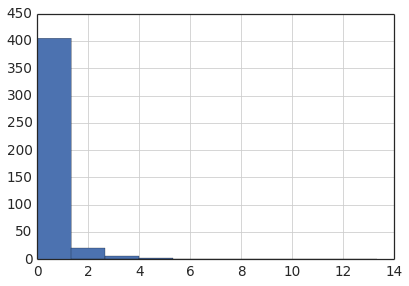

In [19]:
diff.hist()

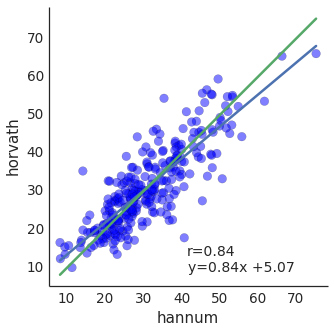

In [20]:
hannum_adj = detrend(aa.AGE.dropna(), aa['hannum']).dropna()
horvath_adj = detrend(aa.AGE.dropna(), aa['horvath']).dropna()
pred_c = (hannum_adj + horvath_adj) / 2
diff = ((hannum_adj - horvath_adj) / ((hannum_adj + horvath_adj) * .5)).abs()
k = ti(diff < .3)
pred_c = detrend(aa.AGE.ix[k].dropna(), pred_c)
#aa['pred'] = pred_c
plot_regression(hannum_adj, horvath_adj)

In [21]:
def detrend_ma(ss):
    hannum_adj = detrend(ss.AGE.dropna(), ss['hannum'])
    horvath_adj = detrend(ss.AGE.dropna(), ss['horvath'])
    pred_c = (hannum_adj + horvath_adj) / 2
    pred_c_adj = detrend(ss.AGE, pred_c)
    return pred_c_adj

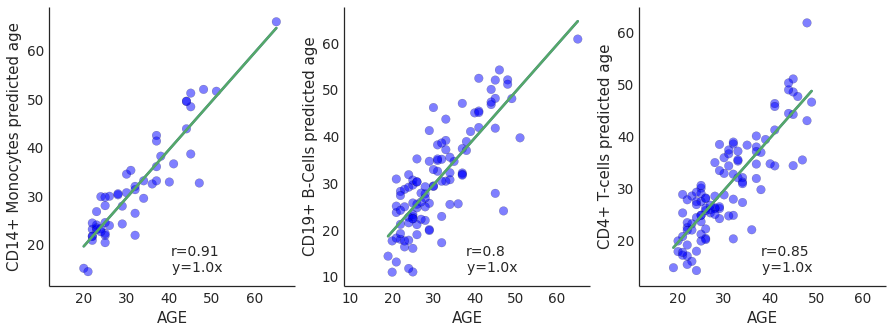

In [22]:
fig, axs = subplots(1,3, figsize=(15,5))
ct = ['CD14+ Monocytes', 'CD19+ B-Cells', 'CD4+ T-cells']
ff = aa.patient.isin(ti(aa[aa.cell_type.isin(ct)].patient.value_counts() > 1))
ff = ti(ff)
for i,c in enumerate(ct):
    idx = ti(aa.cell_type == c).intersection(ff)
    plot_regression(aa.AGE, detrend_ma(aa.ix[idx]), ax=axs[i])
    axs[i].set_ylabel('{} predicted age'.format(c))

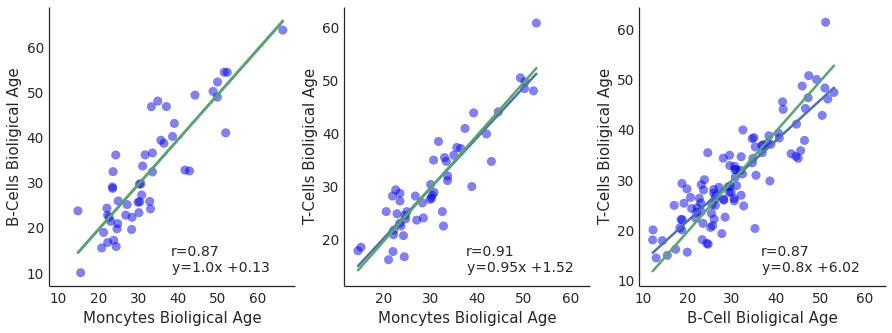

In [23]:
d1 = aa[aa.cell_type == 'CD14+ Monocytes'].set_index('patient')
d2 = aa[aa.cell_type == 'CD19+ B-Cells'].set_index('patient')
d3 = aa[aa.cell_type == 'CD4+ T-cells'].set_index('patient')

fig, axs = subplots(1,3, figsize=(15,5))

    
idx1 = d1.index.intersection(d2.index)
v1 = detrend_ma(d1.ix[idx1]) 
v2 = detrend_ma(d2.ix[idx1])
plot_regression(v1, v2, ax=axs[0])
axs[0].set_xlabel('Moncytes Bioligical Age')
axs[0].set_ylabel('B-Cells Bioligical Age')

idx2 = d1.index.intersection(d3.index)
v1 = detrend_ma(d1.ix[idx2]) 
v2 = detrend_ma(d3.ix[idx2]) 
plot_regression(v1, v2, ax=axs[1])
axs[1].set_xlabel('Moncytes Bioligical Age')
axs[1].set_ylabel('T-Cells Bioligical Age')

idx3 = d2.index.intersection(d3.index)
v1 = detrend_ma(d2.ix[idx3]) 
v2 = detrend_ma(d3.ix[idx3])
plot_regression(v1, v2, ax=axs[2])
axs[2].set_xlabel('B-Cell Bioligical Age')
axs[2].set_ylabel('T-Cells Bioligical Age')

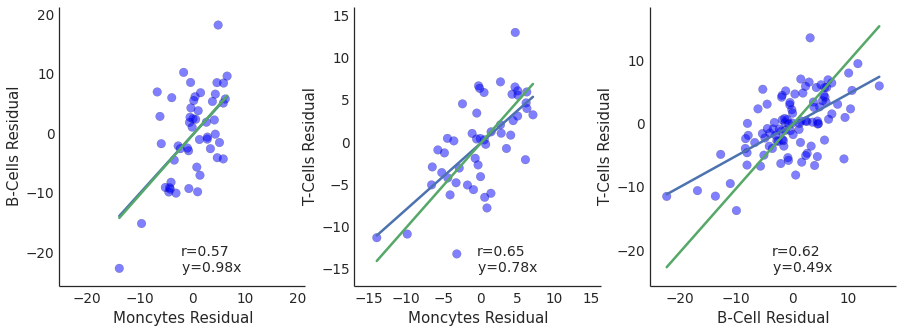

In [24]:
d1 = aa[aa.cell_type == 'CD14+ Monocytes'].set_index('patient')
d2 = aa[aa.cell_type == 'CD19+ B-Cells'].set_index('patient')
d3 = aa[aa.cell_type == 'CD4+ T-cells'].set_index('patient')

fig, axs = subplots(1,3, figsize=(15,5))

    
idx1 = d1.index.intersection(d2.index)
v1 = detrend_ma(d1.ix[idx1]) - d1.AGE
v2 = detrend_ma(d2.ix[idx1]) - d2.AGE
plot_regression(v1, v2, ax=axs[0])
axs[0].set_xlabel('Moncytes Residual')
axs[0].set_ylabel('B-Cells Residual')

idx2 = d1.index.intersection(d3.index)
v1 = detrend_ma(d1.ix[idx2]) - d1.AGE
v2 = detrend_ma(d3.ix[idx2]) - d3.AGE
plot_regression(v1, v2, ax=axs[1])
axs[1].set_xlabel('Moncytes Residual')
axs[1].set_ylabel('T-Cells Residual')

idx3 = d2.index.intersection(d3.index)
v1 = detrend_ma(d2.ix[idx3]) - d2.AGE
v2 = detrend_ma(d3.ix[idx3]) - d3.AGE
plot_regression(v1, v2, ax=axs[2])
axs[2].set_xlabel('B-Cell Residual')
axs[2].set_ylabel('T-Cells Residual')

In [25]:
idx1 = d1.index.intersection(d2.index)
v1 = detrend_ma(d1.ix[idx1]) - d1.AGE
v2 = detrend_ma(d2.ix[idx1]) - d2.AGE
pearson_pandas(v1, v2)

rho    5.74e-01
p      1.04e-05
dtype: float64

In [26]:
idx2 = d1.index.intersection(d3.index)
v1 = detrend_ma(d1.ix[idx2]) - d1.AGE
v2 = detrend_ma(d3.ix[idx2]) - d3.AGE
pearson_pandas(v1, v2)

rho    6.53e-01
p      2.72e-07
dtype: float64

In [27]:
idx3 = d2.index.intersection(d3.index)
v1 = detrend_ma(d2.ix[idx3]) - d2.AGE
v2 = detrend_ma(d3.ix[idx3]) - d3.AGE
pearson_pandas(v1, v2)

rho    6.21e-01
p      5.60e-12
dtype: float64

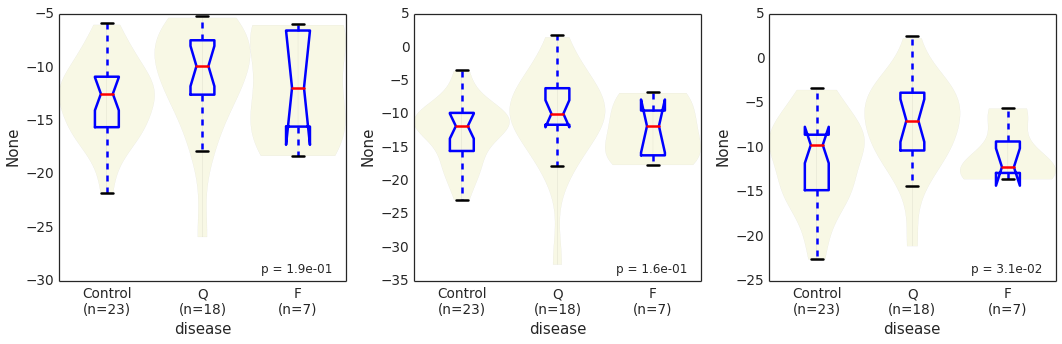

In [39]:
fig, axs = subplots(1,3, figsize=(15,5))

violin_plot_pandas(d1.disease, (d1.pred - d1.AGE).dropna(), ax=axs[0])
violin_plot_pandas(d2.disease, (d2.pred - d2.AGE).dropna(), ax=axs[1])
violin_plot_pandas(d3.disease, (d3.pred - d3.AGE).dropna(), ax=axs[2])
fig.tight_layout()

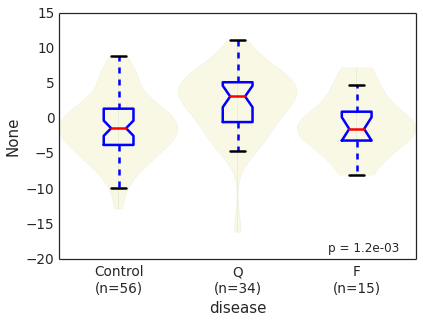

In [102]:
a2 = pred_c.groupby(aa.patient).mean()
dd = aa.groupby('patient').first()['disease']
age = aa.groupby('patient').first()['AGE']
violin_plot_pandas(dd, (a2 - age).dropna())

In [103]:
(a2 - age).groupby(dd).mean()

disease
Control   -1.23
F         -0.80
Q          2.24
dtype: float64

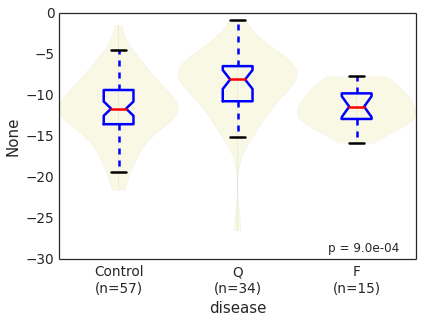

In [110]:
a2 = aa.groupby('patient').mean()
dd = aa.groupby('patient').first()['disease']
violin_plot_pandas(dd, (a2.pred - a2.AGE).dropna())

In [113]:
cell_type.value_counts()

CD4+ T-cells                      149
CD19+ B-Cells                     104
CD14+ Monocytes                    55
CD25+CD127- Regulatory T-cells     42
CD45RO+RA- Memory T-cells          42
CD45RO-RA+ Naive T-cells           42
dtype: int64

In [119]:
df = data.ix[:, ti(cell_type == 'CD19+ B-Cells')]
df = logit_adj(df)
pt = df.columns

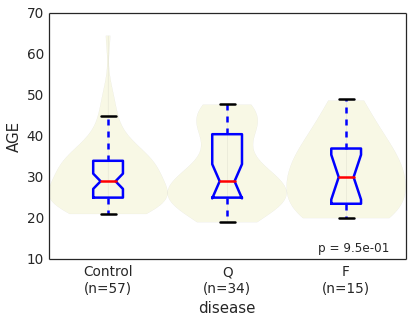

In [149]:
d = aa.query('cell_type == "CD19+ B-Cells"').set_index('patient').disease
violin_plot_pandas(d, age)

In [167]:
df = df.rename(columns=patient)
pt = df.columns
age_corr_b = df.T.ix[pt].corrwith(age.ix[pt].astype(float))

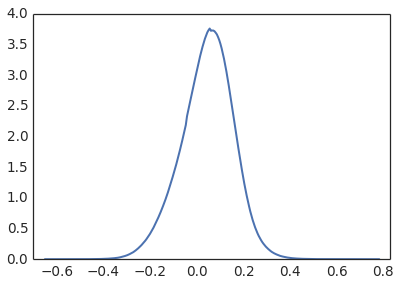

In [168]:
draw_dist(age_corr_b)

In [170]:
age_corr_b.to_csv('/cellar/users/agross/Data/Methylation_Controls/Beta_age_corr.csv')